# Contenuti
- [Alberi decisionali](#Alberi-decisionali)
- [Dataset](#Dataset)
- [Esercizio 1](#Esercizio-1)
- [Alberi decisionali con Scikit-learn](#Alberi-decisionali-con-Scikit-learn)
- [Esercizio 2](#Esercizio-2)
- [Struttura dell'albero](#Struttura-dell'albero)
- [Tuning degli iperparametri](#Tuning-degli-iperparametri)
- [Esercizio 3](#Esercizio-3)

# Alberi decisionali

Nell'esercitazione odierna si vedrà come utilizzare gli alberi decisionali per la risoluzione di un problema di classificazione binario e in seguito ad un problema di classificazione multiclasse.

Prima di addentrarci sulle funzioni messe a disposizione dalla libreria **Scikit-learn** andremo a costruire un piccolo classificatore a regole che simula il comportamento di un albero decisionale. Infatti durante le lezioni teoriche abbiamo visto come funziona la classificazione con alberi decisionali e come ciascun percorso radice foglia rappresenti una regola di classificazione. In questo caso lavoreremo in direzione opposta definendo direttamente delle regole di classificazione (in modo algoritmico) estendendo il classificatore binario 1-d realizzato nell'esercitazione precedente.

# Dataset
La libreria **Scikit-learn** mette a disposizione anche numerosi dataset per eseguire esercitazioni/tutorial/esperimenti, alcuni dei quali "giocattolo" altri più simili ad applicazini reali. Il dataset che useremo per questa esercitazione è estratto dai dataset giocattolo (toy dataset) che potete trovare nella [documentazione](https://scikit-learn.org/stable/datasets.html) e si chiama Iris Plant dataset. E' uno dei dataset più conosciuti nella letteratura del Machine Learning, proposto in un articolo scientifico negli anni 50 che viene citato frequentemente ancora oggi. Il set di dati contiene 3 classi di 50 istanze ciascuna, dove ogni classe si riferisce a un tipo di pianta di iris. Ogni record è rappresentato da 4 attributi numerici che definiscono la lunghezza e larghezza di sepali e petali. Per caricare il dataset è necessario importare il modulo della libreria che lo contiene per poi richiamarla all'interno del codice.

In [21]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
print(X.shape)
print(y.shape)

(150, 4)
(150,)


Inizialmente per semplificare il problema lavoreremo con solo 2 classi e sole 2 dimensioni.

In [22]:
#riduciamo il numero di attributi a 2
X = X[:,2:4]
#con una indicizzazione booleana eliminiamo la classe 0
X = X[y!=0,:]
y = y[y!=0]
#utile perconvertire le label (attualmente con valori 1 e 2) nei valori 0 e 1
y =  y -1
print(X.shape)
print(y.shape)

(100, 2)
(100,)


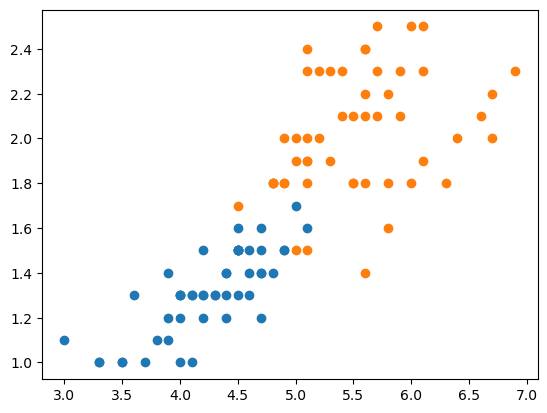

In [23]:
#facciomo lo scatterplot 2D per verificare la separazione tra le classi
import matplotlib.pyplot as plt

x1 = X[y==0,:]
y1 = y[y==0]

x2 = X[y==1,:]
y2 = y[y==1]

plt.scatter(x1[:,0], x1[:,1])
plt.scatter(x2[:,0], x2[:,1])
plt.show()

Dato che il dataset non è partizionato lo suddivideremo in due parti, training e test set, per addestrare il classificatore atraverso il training set e simulare le prestazioni dei modelli su dati nuovi/non visti. Per ulteriori dettagli sulla procedura train_test_split si rimanda all'esercitazione 3.

In [24]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=0, test_size=0.25)
print('Shape training set:', train_x.shape)
print('Shape validation set:', test_x.shape)

Shape training set: (75, 2)
Shape validation set: (25, 2)


## Esercizio 1

Modificare il classificatore binario 1-d realizzato nell'esercitazione precedente in modo che possa gestire 2 dimensioni definendo delle regole di classificazione (in modo algoritmico) simili a quelle di un albero decisionale.

Utilizzando il codice prodotto nelle esercitazioni precedenti calcolare le prestazioni di questo classificatore.

In [72]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def analysis(cm):
    TP, FN, FP , TN = (cm[0,0],cm[0,1],cm[1,0],cm[1,1])
    tpr = TP/(TP+FN)
    tnr = TN/(TN+FP)
    fpr = FP/(TN+FP)
    fnr = FN/(TP+FN)
    p = TP/(FP+TP)
    f = (2 * tpr * p) / (p + tpr)
    return[tpr,tnr,fpr,fnr,p,f]

class BetterClassifier2D:
    def __init__(self):
        self.soglia = [lambda att: False]

    def binning(self,x,y):
        xmax = max(x)
        xmin = min(x)
        nbins = 20 # numero di bin in cui suddividere l'intervalolo
        binspan = (xmax-xmin)/nbins # grandezza di ciasun bin
        ranges = [xmin + i*binspan for i in range(nbins)] # creo i range dei bin
        bins = [y[x > r] for r in ranges] # creo i bin
        diffbins1 = np.array([(len(b[b==0])-len(b[b==1])) for b in bins]) # differenza tra numero di oggetti delle classi nei bin
        absdiffbins1 = [abs(e) for e in diffbins1] # valore assoluto dei diff
        print(absdiffbins1)
        idx_max= np.argmax(absdiffbins1) # indice massimo della differenza
        soglia1 =ranges[idx_max+1] # soglia
        print(soglia1)
        if diffbins1[idx_max]<0:
            return lambda att : 0 if att<soglia1 else 1
        else:
            return  lambda att : 0 if att>soglia1 else 1
 
    def fit(self,x,y):
        if len(x.shape)<2:
            x = [x]
            k = 1
        else:
            k = x.shape[1]
        self.soglia = [self.binning(x[:,ki],y) for ki in range(k)]

    def predict(self,x):
        if len(x.shape)<2:
            x = [x]
            k = 1
        else:
            k = x.shape[1]
        res=np.zeros(x.shape,dtype=np.int32)
        for ki in range(k):
            res[:,ki] = [self.soglia[ki](rec) for rec in x[:,ki]]
        return np.array([max(row) for row in res])

bc = BetterClassifier2D()
bc.fit(train_x,train_y)
pred_y = bc.predict(test_x)
print(pred_y[0:25])
print(test_y[0:25])
cm1 = confusion_matrix(pred_y,test_y)

print(analysis(cm1))

[2, 2, 2, 4, 6, 9, 16, 20, 29, 35, 33, 25, 22, 18, 12, 9, 5, 4, 3, 1]
4.95
[6, 6, 8, 12, 22, 22, 26, 31, 32, 32, 32, 25, 21, 21, 16, 13, 11, 11, 5, 3]
1.6749999999999998
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0]
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
[1.0, 0.9230769230769231, 0.07692307692307693, 0.0, 0.9230769230769231, 0.9600000000000001]


# Alberi decisionali con Scikit-learn
Di seguito vengono descritte le operazioni necessarie per creare e addestrare un albero decisionale facendo uso della libreria **Scikit-learn**. Come già detto, uno dei punti di forza di questa libreria è la sua facilità d'uso e l'uniformità delle chiamate alla libreria. Infatti anche gli alberi decisionali possono essere addestrati tramite il metodo **.fit(...)** che prende in input un insieme di record etichettati X,y, e possono predirre la classe di uno o più pattern in input tramite il metodo **.predict(...)**.

Come per gli altri classificatori in Scikit-learn dobbiamo creare un'istanza della classe e poi procedere all'addestramento. 
Il classificatore in questo caso è un [**DecisionTreeClassifier(...)**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Nel codice qui sotto, è impostato l'iperparametro max_depth = 2 per pre-potare l'albero e assicurare che non abbia una profondità superiore a 2. Si noti anche il random_state = 0, in modo che possiate ottenere tutti gli stessi risultati.

In [77]:
from sklearn.tree import DecisionTreeClassifier

#istanza di un albero di classificazione con profondità 3
dTree_clf = DecisionTreeClassifier(max_depth=2, random_state=0)

Ora possiamo procedere con l'addestramento del modello tramite il metodo **.fit(...)** che prende in input un insieme di record etichettati X,y.

In [78]:
# Addestramento
dTree_clf.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=2, random_state=0)

Possiamo verificare i parametri del nostro classificatore tramite il metodo **get_params()**. 

In [80]:
dTree_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

Una volta addestrato, un classificatore può essere utilizzato per riconoscere la classe di uno o più pattern. Per fare ciò, si può utilizzare il metodo **.predict(...)** passando come parametro una lista di pattern. Il risultato che si ottiene è una lista delle label predette dal classificatore.

In [84]:
# Uso della funzione .predict(...)
pred_y = dTree_clf.predict(test_x)
# Per verificare il valore delle predizioni ne mostriamo un sotto-insieme
print('Classi predette:', pred_y[0:10])
print('Classi reali:', test_y[0:10])

Classi predette: [1 1 1 1 1 1 0 1 1 1]
Classi reali: [0 1 0 1 1 1 0 1 1 1]


Anche in questo caso attraverso il metodo **.predict_proba(...)**, che prende in input sempre una lista di pattern, è possibile verificare con quale valore di probabilità i pattern sono classificati come appartenenti ad una classe o ad un'altra. Il risultato che si ottiene quindi non è più una lista di label ma una matrice con *c* colonne (pari al numero di classi). 

In [86]:
# Uso della funzione .predict_proba(...)
pred_prob_y = dTree_clf.predict_proba(test_x)
# Per verificare il valore delle predizioni ne mostriamo un sotto-insieme
print('Classi reali:', test_y[0:10])
print('Classi predette:', pred_prob_y[0:10,1])

Classi reali: [0 1 0 1 1 1 0 1 1 1]
Classi predette: [0.75 1.   0.75 1.   1.   1.   0.   0.75 1.   1.  ]


Come potete notare, a differenza del classificatore dummy, i valori di probabilità restituiti non coincidono con i valori delle label predette, ma sono dei valori floating point che possono essere utilizzati per svariati calcoli, incluso la curva ROC. Allo stesso tempo è possibile notare che la maggior parte dei valori coincidono tra loro. Se vi state chiedendo perchè vi incoraggio a controllare il codice per verificare come vengono eseguite le predizioni.

## Esercizio 2

Calcolare e confrontare le prestazioni di questo albero decisionali con le prestazioni del classificatore binario 2D definito nel precedente esercizio.

Scrivere una funzione per il calcolo e il plot della curva ROC. Quindi calcolare e fare il plot della curva ROC per l'albero decisionale appena creato.

#### Suggerimenti

Potete usare la funzione di **Scikit-learn** per il calcolo dei punti della curva [**roc_curve(...)**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve).

[0.         0.30769231 1.        ] [0. 1. 1.] [2 1 0]


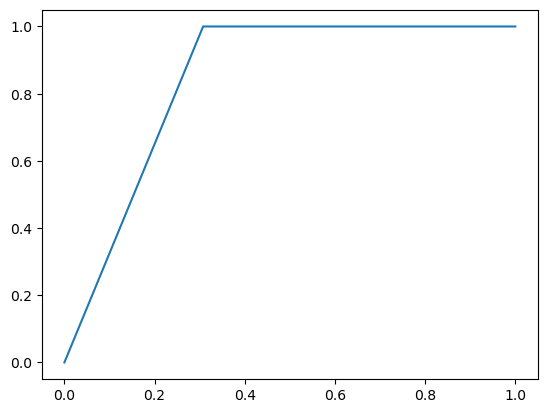

In [100]:
#Scrivi qui la soluzione
import sklearn
(fpr,tpr,thresholds) = sklearn.metrics.roc_curve(test_y,pred_y)
print(fpr,tpr,thresholds)
plt.plot(fpr,tpr)

Anche la curva ROC (come la matrice di confusione) può essere estesa ai casi Multi-classe. Si rimanda alla [**documentazione**](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) per un approfondimento.

# Struttura dell'albero

Gli alberi decisionali hanno un attributo chiamato ``tree_`` che permette l'accesso ad attributi di basso livello come ``node_count``, il numero totale di nodi, e ``max_depth``, la profondità massima dell'albero. Inoltre, memorizza l'intera struttura dell'alberoo, rappresentata come una serie di array paralleli. L'elemento i-esimo elemento di ogni array contiene informazioni sul nodo ``i``. Il nodo 0 è la radice dell'albero. Alcuni degli array si applicano solo alle foglie o ai nodi di split. In questo caso i valori dei nodi dell'altro tipo sono arbitrari. Per esempio, gli array ``feature`` e ``threshold`` si applicano solo ai nodi di split. I valori dei nodi foglia in questi array sono quindi arbitrari.

Tra questi array, abbiamo:

  - ``children_left[i]``: id del figlio sinistro del nodo ``i`` o -1 se è una foglia
    nodo
  - ``children_right[i]``: id del figlio destro del nodo ``i`` o -1 se è un nodo foglia
    nodo
  - ``feature[i]``: caratteristica utilizzata per la suddivisione del nodo ``i``
  - ``threshold[i]``: valore di soglia al nodo ``i``
  - ``n_node_samples[i]``: numero di campioni di addestramento che raggiungono il nodo ``i``
  - ``impurity[i]``: l'impurità al nodo ``i``.

Utilizzando gli array, si può attraversare la struttura ad albero per calcolare varie proprietà. Qui di seguito, calcoleremo la profondità di ogni nodo e se è una foglia.

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

#Carichiamo nuovamente il dataset che era stato modificato in precedenza
iris = load_iris()
X = iris.data
y = iris.target

#riduciamo il numero di attributi a 2
X = X[:,2:4]

train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=0, test_size=0.25)
print('Shape training set:', train_x.shape)
print('Shape validation set:', test_x.shape)

#instanziomo e addestriamo quindi l'albero di classificazione con profondità 3 su tutte le classi
dTree_clf = DecisionTreeClassifier(max_depth=2, random_state=0)
dTree_clf.fit(train_x, train_y)

Shape training set: (112, 2)
Shape validation set: (38, 2)


DecisionTreeClassifier(max_depth=2, random_state=0)

In [105]:
import numpy as np
n_nodes = dTree_clf.tree_.node_count
children_left = dTree_clf.tree_.children_left
children_right = dTree_clf.tree_.children_right
feature = dTree_clf.tree_.feature
threshold = dTree_clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print("l'albero decisionale ha {n} nodi la seguente struttura".format(n=n_nodes))

for i in range(n_nodes):
    if is_leaves[i]:
        print("{space}node={node} è un nodo foglia.".format(space=node_depth[i] * "\t", node=i))
    else:
        print("{space}node={node} è un nodo di split che va a {left} se X[:, {feature}] <= {threshold} altrimenti a {right}."
                .format(space=node_depth[i] * "\t", node=i, left=children_left[i], feature=feature[i], threshold=threshold[i], right=children_right[i],
            )
        )

l'albero decisionale ha 5 nodi la seguente struttura
node=0 è un nodo di split che va a 1 se X[:, 1] <= 0.800000011920929 altrimenti a 2.
	node=1 è un nodo foglia.
	node=2 è un nodo di split che va a 3 se X[:, 0] <= 4.950000047683716 altrimenti a 4.
		node=3 è un nodo foglia.
		node=4 è un nodo foglia.


Un modo alternativo e decisamente più intuitivo (e semplice) è quello di utilizzare la funzione **plot_tree(...)** di **Scikit-learn** che integra le funzionalità di **matplotlib**. Questa funzione prende in input l'istanza dell'albero decisionale e fa il plot dell'intera struttura e, per ogni nodo, il valore della misura di impurezza (es. Gini), il numero di campioni che raggiunge il nodo, il valore e in più nei nodi di split è presente il valori di split.

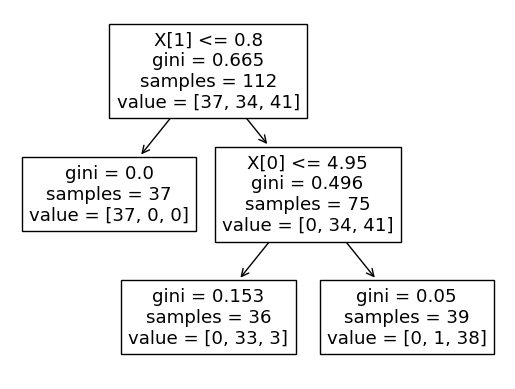

In [106]:
from sklearn.tree import plot_tree

plot_tree(dTree_clf)
plt.show()

Per rendere ulteriormente più leggibile la struttura dell'albero è possibile inserire come ulteriori parametri i nomi delle classi e delle features.

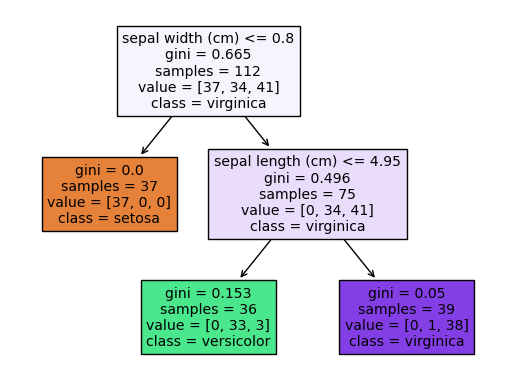

In [108]:
#utilizziamo i nomi delle features e delle classi che abbiamo usato in fase di induzione
fn = iris.feature_names
cn = iris.target_names
plot_tree(dTree_clf, feature_names = fn, class_names=cn, filled = True);

# Tuning degli iperparametri

Il modello addestrato finora in questa esercitazione aveva una profondità massima pari a 2, valore utilizzato per eseguire una potatura preventiva. Tuttavia, supponiamo di voler migliorare le prestazioni per poter fare previsioni migliori su dati non visti. Se da un lato si possono aggiungere al modello altre caratteristiche, dall'altro un altro modo per migliorare le prestazioni è la regolazione degli iperparametri, che consiste nel selezionare i valori ottimali per un problema di apprendimento automatico. Questi parametri di regolazione sono spesso chiamati iperparametri. Prima di procedere alla messa a punto degli iperparametri, è necessario fare un passo indietro e analizzare brevemente la differenza tra parametri e iperparametri.

## Parametri e iperparametri

Un algoritmo di apprendimento automatico stima i parametri del modello per un dato insieme di dati e aggiorna questi valori man mano che continua a imparare. Si può pensare a un parametro del modello come a un valore appreso applicando il processo di addestramento. Ad esempio, per gli alberi decisionali il criterio di split. Gli iperparametri o parametri di regolazione sono metaparametri che influenzano il processo di fitting stesso. Vedremo in seguito che altre tecniche di classificazione hanno numerosi iperparametri. Se per ora tutto questo suona confuso, Jason Brownlee ha una buona regola empirica: "Se si deve specificare manualmente un parametro del modello, probabilmente si tratta di un iperparametro del modello".

## Tuning del valore di max_depth
Esistono molti modi diversi per mettere a punto un iperparametro di un albero decisionale. Un modo è quello di sintonizzare l'iperparametro ``max_depth``. Il codice seguente mostra l'accuratezza degli alberi decisionali con diversi valori di ``max_depth``.

In [113]:
max_depth_range = list(range(1, 25))
acc = []
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth = depth, random_state = 0)
    clf.fit(train_x, train_y)      
    score = clf.score(test_x, test_y)
    acc = acc + [score]
    print("Il valore di accuratezza per un albero di profondità ", depth, " è pari a : ", score)

Il valore di accuratezza per un albero di profondità  1  è pari a :  0.5789473684210527
Il valore di accuratezza per un albero di profondità  2  è pari a :  0.8947368421052632
Il valore di accuratezza per un albero di profondità  3  è pari a :  0.9736842105263158
Il valore di accuratezza per un albero di profondità  4  è pari a :  0.9736842105263158
Il valore di accuratezza per un albero di profondità  5  è pari a :  0.9473684210526315
Il valore di accuratezza per un albero di profondità  6  è pari a :  0.9473684210526315
Il valore di accuratezza per un albero di profondità  7  è pari a :  0.9473684210526315
Il valore di accuratezza per un albero di profondità  8  è pari a :  0.9473684210526315
Il valore di accuratezza per un albero di profondità  9  è pari a :  0.9473684210526315
Il valore di accuratezza per un albero di profondità  10  è pari a :  0.9473684210526315
Il valore di accuratezza per un albero di profondità  11  è pari a :  0.9473684210526315
Il valore di accuratezza per u

Possiamo già osservare quale valore di max_depth permette di ottenere i migliori risultati, ma lo possiamo osservare ancora meglio in maniera grafica.

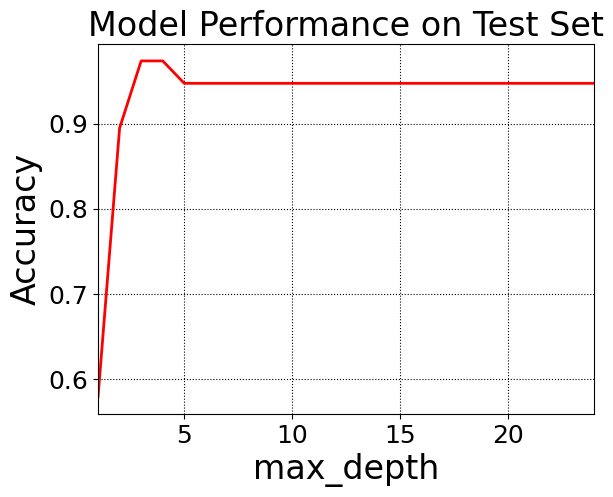

In [115]:
plt.plot(max_depth_range, acc, lw=2, color='r')
plt.xlim([1, max(max_depth_range)])
plt.grid(True, axis = 'both', zorder = 0, linestyle = ':', color = 'k')
plt.tick_params(labelsize = 18)
plt.xlabel('max_depth', fontsize = 24)
plt.ylabel('Accuracy', fontsize = 24)
plt.title('Model Performance on Test Set', fontsize = 24)
plt.show()

Si noti che il modello di cui sopra potrebbe comunque essere stato adattato in modo eccessivo all'insieme di test, poiché il codice ha modificato ripetutamente max_depth per ottenere il modello migliore. In altre parole, la conoscenza dell'insieme di test potrebbe essere trapelata nel modello quando il codice ha iterato 24 valori diversi per max_depth (la lunghezza di max_depth_range è 24). Ciò ridurrebbe la potenza della nostra metrica di valutazione, poiché non sarebbe più un indicatore così forte delle prestazioni di generalizzazione. 

Questo è il motivo per cui nella vita reale, durante la regolazione degli iperparametri, si utilizzano un set di training di test e di validazione. Inoltre il valore trovato è molto dipendende dalla specifica composizione del training e del test set.

## Esercizio 3

Eseguire la procedura di tuning del parametro max_depth utilizzando un set di validazione e mettere a confronto (attraverso un plot come quello mostrato in precedenza) l'andamento delle prestazioni nei set di training, di test e di validazione.

Per evitare che il risultato sia troppo dipendente dalla specifica composizione del training e del test set, migliorare il codice precedente per eseguire una procedura di validazione esaustiva.

#### Suggerimenti
Potete usare le funzioni di **Scikit-learn** per la cross-validation: es. [**Kfold(...)**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) o [**cross_validate(...)**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate).

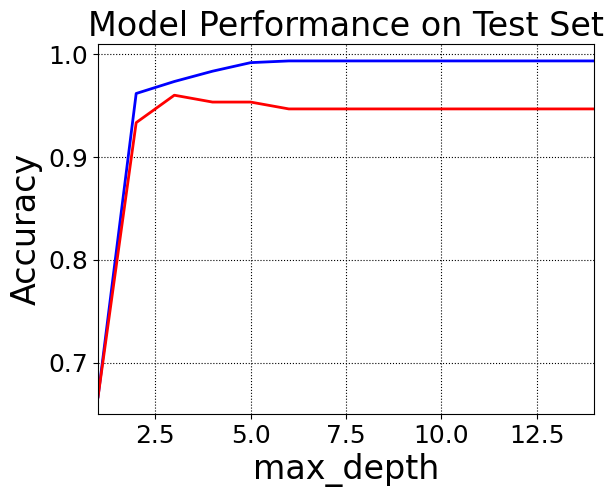

In [125]:
max_depth_range = list(range(1, 15))
acc_test = []
acc_train = []
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth = depth, random_state = 0)
    score = sklearn.model_selection.cross_validate(clf,X,y,return_train_score=True)
    acc_test = acc_test + [np.mean(score["test_score"])]
    acc_train = acc_train +[np.mean(score["train_score"])]
    # clf.fit(train_x, train_y)      
    # score = clf.score(test_x, test_y)
    # acc = acc + [score]
plt.plot(max_depth_range, acc_train, lw=2, color='b')
plt.plot(max_depth_range, acc_test, lw=2, color='r')
plt.xlim([1, max(max_depth_range)])
plt.grid(True, axis = 'both', zorder = 0, linestyle = ':', color = 'k')
plt.tick_params(labelsize = 18)
plt.xlabel('max_depth', fontsize = 24)
plt.ylabel('Accuracy', fontsize = 24)
plt.title('Model Performance on Test Set', fontsize = 24)
plt.show()